<a href="https://colab.research.google.com/github/ArkS0001/Liquid-Neural-Network/blob/main/LNN_CAR_FAILED_LEARNINGRATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a single Liquid Neuron
class LiquidNeuron(nn.Module):
    def __init__(self, input_size):
        super(LiquidNeuron, self).__init__()
        self.input_size = input_size
        # Learnable parameters for state update
        self.alpha = nn.Parameter(torch.rand(input_size))
        self.beta = nn.Parameter(torch.rand(input_size))
        # Initial state
        self.state = torch.zeros(input_size)

    def forward(self, x):
        # Detach the state to prevent backward graph issues
        self.state = self.alpha * self.state.detach() + self.beta * x
        # Apply ReLU activation
        return F.relu(self.state)


# Define the Liquid Neural Network
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.liquid_neuron = LiquidNeuron(input_size)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Pass input through Liquid Neuron layer
        x = self.liquid_neuron(x)
        # Pass through fully connected layer
        x = self.fc(x)
        return x

# Hyperparameters
input_size = 10
hidden_size = 10  # Not explicitly used in this implementation
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = LiquidNeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Generate dummy data for training
inputs = torch.randn(100, input_size)  # 100 samples, each with `input_size` features
targets = torch.randn(100, output_size)  # 100 corresponding target outputs

# Training loop
for epoch in range(num_epochs):
    for i in range(len(inputs)):
        input = inputs[i]
        target = targets[i]

        # Forward pass
        output = model(input)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
test_input = torch.randn(1, input_size)  # Single test sample
test_output = model(test_input)
print("Test Input:", test_input)
print("Test Output:", test_output)


Epoch [10/100], Loss: 0.6940
Epoch [20/100], Loss: 0.7984
Epoch [30/100], Loss: 0.7496
Epoch [40/100], Loss: 0.7251
Epoch [50/100], Loss: 0.6816
Epoch [60/100], Loss: 0.6718
Epoch [70/100], Loss: 0.7680
Epoch [80/100], Loss: 0.8733
Epoch [90/100], Loss: 0.7968
Epoch [100/100], Loss: 0.9530
Test Input: tensor([[-0.8567, -0.1968, -1.3150, -0.3474, -0.9131, -0.6158,  0.3094, -0.2706,
          0.2332, -0.1996]])
Test Output: tensor([[-0.1948]], grad_fn=<AddmmBackward0>)


Epoch 50/500, Loss: 494.4261
Epoch 100/500, Loss: 494.4261
Epoch 150/500, Loss: 494.4261
Epoch 200/500, Loss: 494.4261
Epoch 250/500, Loss: 494.4261
Epoch 300/500, Loss: 494.4261
Epoch 350/500, Loss: 494.4261
Epoch 400/500, Loss: 494.4261
Epoch 450/500, Loss: 494.4261
Epoch 500/500, Loss: 494.4261


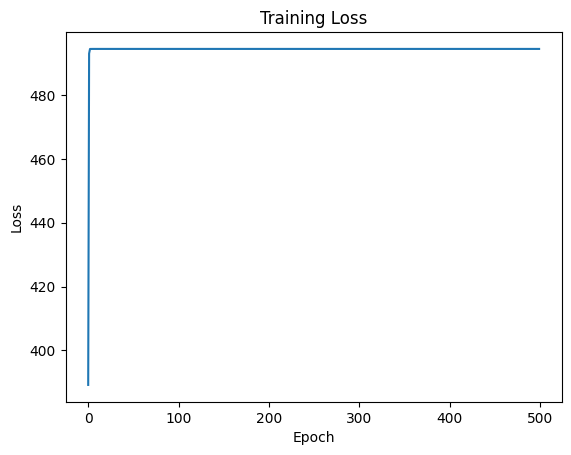

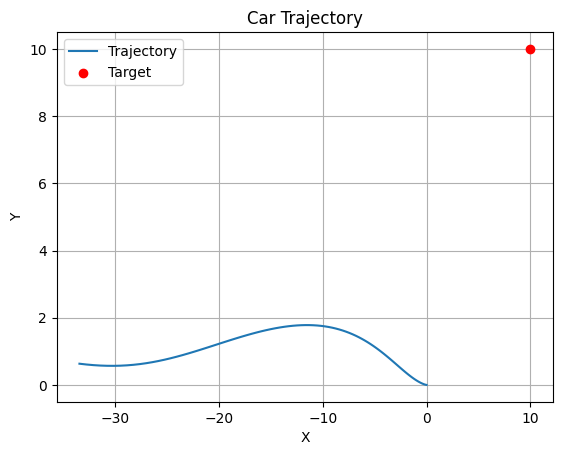

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define a single Liquid Neuron
class LiquidNeuron(nn.Module):
    def __init__(self, input_size):
        super(LiquidNeuron, self).__init__()
        self.alpha = nn.Parameter(torch.rand(input_size))
        self.beta = nn.Parameter(torch.rand(input_size))
        self.state = torch.zeros(input_size)

    def forward(self, x):
        self.state = self.alpha * self.state.detach() + self.beta * x
        return torch.tanh(self.state)  # Use tanh for smoother output

# Define the Liquid Neural Network Controller
class CarController(nn.Module):
    def __init__(self, input_size, output_size):
        super(CarController, self).__init__()
        self.liquid_neuron = LiquidNeuron(input_size)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.liquid_neuron(x)
        return self.fc(x)

# Simulate the car dynamics
class CarSimulator:
    def __init__(self, dt=0.1):
        self.x = 0.0  # Position x
        self.y = 0.0  # Position y
        self.theta = 0.0  # Orientation
        self.v = 0.0  # Velocity
        self.dt = dt  # Time step

    def step(self, acceleration, steering):
        # Update velocity and orientation
        self.v += acceleration * self.dt
        self.theta += steering * self.dt

        # Update position based on velocity and orientation
        self.x += self.v * np.cos(self.theta) * self.dt
        self.y += self.v * np.sin(self.theta) * self.dt

        return np.array([self.x, self.y, self.theta, self.v], dtype=np.float32)

def train_controller():
    input_size = 4  # [x, y, theta, v]
    output_size = 2  # [acceleration, steering]
    model = CarController(input_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Define the simulator
    simulator = CarSimulator()
    target_position = np.array([10.0, 10.0])  # Target position

    num_epochs = 500
    history = []

    for epoch in range(num_epochs):
        # Reset simulator
        simulator = CarSimulator()
        state = np.array([simulator.x, simulator.y, simulator.theta, simulator.v], dtype=np.float32)

        for t in range(100):  # Simulate for 100 steps
            # Convert state to a tensor with requires_grad=True
            state_tensor = torch.tensor(state, dtype=torch.float32, requires_grad=True)
            action = model(state_tensor)  # Get action from the controller

            # Apply action to the simulator
            acceleration, steering = action.detach().numpy()
            state = simulator.step(acceleration, steering)

            # Compute reward based on distance to target
            distance = np.linalg.norm([state[0] - target_position[0], state[1] - target_position[1]])
            reward = -distance

            # Target: minimize distance and stabilize velocity
            target_state = np.array([target_position[0], target_position[1], 0.0, 1.0], dtype=np.float32)
            target_tensor = torch.tensor(target_state, dtype=torch.float32)

            # Compute loss
            loss = criterion(state_tensor, target_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        history.append(loss.item())
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

    # Plot the loss
    plt.plot(history)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    return model


# Evaluate the trained controller
def evaluate_controller(model):
    simulator = CarSimulator()
    target_position = np.array([10.0, 10.0])
    trajectory = []

    for t in range(100):  # Simulate for 100 steps
        state = np.array([simulator.x, simulator.y, simulator.theta, simulator.v], dtype=np.float32)
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action = model(state_tensor)

        acceleration, steering = action.detach().numpy()
        simulator.step(acceleration, steering)
        trajectory.append((simulator.x, simulator.y))

    # Plot the trajectory
    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 0], trajectory[:, 1], label="Trajectory")
    plt.scatter(*target_position, color='red', label="Target", zorder=5)
    plt.title("Car Trajectory")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

# Main execution
if __name__ == "__main__":
    model = train_controller()
    evaluate_controller(model)


In [8]:
pip install gym numpy torch matplotlib

Define the Car Environment

In [10]:
# import numpy as np
# import gym
# from gym import spaces


# class CarEnv(gym.Env):
#     """
#     Custom Environment for a car to learn driving to a target position.
#     """
#     def __init__(self):
#         super(CarEnv, self).__init__()

#         # Define action and observation space
#         # Actions: [acceleration, steering angle]
#         self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), high=np.array([1.0, 1.0]), dtype=np.float32)

#         # Observations: [x, y, theta (angle), v (velocity)]
#         self.observation_space = spaces.Box(
#             low=np.array([-np.inf, -np.inf, -np.pi, 0.0]),
#             high=np.array([np.inf, np.inf, np.pi, 5.0]),
#             dtype=np.float32
#         )

#         # Target position
#         self.target_position = np.array([10.0, 10.0])

#         # Initialize state
#         self.reset()

#     def reset(self):
#         """
#         Reset the environment to its initial state.
#         """
#         self.state = np.array([0.0, 0.0, 0.0, 0.0])  # [x, y, theta, v]
#         return self.state

#     def step(self, action):
#         """
#         Apply action and update the state.
#         """
#         x, y, theta, v = self.state
#         accel, steering = action

#         # Dynamics update
#         dt = 0.1  # time step
#         v = np.clip(v + accel * dt, 0.0, 5.0)  # Update velocity, clip at max speed
#         theta += steering * dt  # Update steering angle
#         theta = (theta + np.pi) % (2 * np.pi) - np.pi  # Keep theta in [-pi, pi]
#         x += v * np.cos(theta) * dt  # Update x
#         y += v * np.sin(theta) * dt  # Update y

#         self.state = np.array([x, y, theta, v])

#         # Compute distance to target
#         distance = np.linalg.norm(self.target_position - np.array([x, y]))

#         # Reward function: Negative distance to encourage minimizing distance
#         reward = -distance

#         # Done condition: If car is close to target
#         done = distance < 0.5

#         return self.state, reward, done, {}

#     def render(self, mode="human"):
#         """
#         Render the environment (basic console output for now).
#         """
#         print(f"State: {self.state}, Target: {self.target_position}")

import numpy as np
import gym
from gym import spaces

class CarEnv(gym.Env):
    def __init__(self):
        super(CarEnv, self).__init__()
        # Define action and observation space
        self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), high=np.array([1.0, 1.0]), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf, -np.pi, 0.0]),
            high=np.array([np.inf, np.inf, np.pi, 5.0]),
            dtype=np.float32
        )
        # Target position
        self.target_position = np.array([10.0, 10.0])
        # Reset state
        self.reset()

    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0, 0.0])  # [x, y, theta, v]
        return self.state

    def step(self, action):
        x, y, theta, v = self.state
        accel, steering = action

        # Update dynamics
        dt = 0.1  # time step
        v = np.clip(v + accel * dt, 0.0, 5.0)
        theta += steering * dt
        theta = (theta + np.pi) % (2 * np.pi) - np.pi
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt

        self.state = np.array([x, y, theta, v])

        # Compute reward
        distance = np.linalg.norm(self.target_position - np.array([x, y]))
        reward = -distance  # Negative distance as reward

        # Done condition
        done = distance < 0.5

        return self.state, reward, done, {}

    def render(self, mode="human"):
        print(f"State: {self.state}, Target: {self.target_position}")



In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size, bias=False)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

        # Initial hidden state
        self.hidden_state = torch.zeros(hidden_size)

    def forward(self, x):
        # Liquid time constant
        tau = 0.1
        u = self.input_to_hidden(x) + self.hidden_to_hidden(self.hidden_state)
        self.hidden_state = (1 - tau) * self.hidden_state + tau * self.tanh(u)
        output = self.hidden_to_output(self.hidden_state)
        return output


In [12]:
def train_car_controller(env, model, num_episodes=500):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    gamma = 0.99  # Discount factor

    for episode in range(num_episodes):
        state = env.reset()
        episode_loss = 0
        total_reward = 0

        for t in range(200):  # Max steps per episode
            state_tensor = torch.FloatTensor(state)

            # Predict action
            action = model(state_tensor).detach().numpy()
            action = np.clip(action, -1.0, 1.0)

            # Take step in the environment
            next_state, reward, done, _ = env.step(action)

            # Compute loss: Negative reward as loss for gradient descent
            loss = -reward

            # Backpropagation
            optimizer.zero_grad()
            torch_loss = torch.tensor(loss, requires_grad=True)
            torch_loss.backward()
            optimizer.step()

            episode_loss += loss
            total_reward += reward

            state = next_state
            if done:
                break

        print(f"Episode {episode + 1}/{num_episodes}, Loss: {episode_loss:.2f}, Total Reward: {total_reward:.2f}")

    return model


In [13]:
def evaluate_car_controller(env, model):
    state = env.reset()
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state)
        action = model(state_tensor).detach().numpy()
        action = np.clip(action, -1.0, 1.0)
        state, _, done, _ = env.step(action)
        env.render()


In [14]:
if __name__ == "__main__":
    env = CarEnv()
    input_size = env.observation_space.shape[0]
    hidden_size = 64
    output_size = env.action_space.shape[0]

    model = LiquidNeuralNetwork(input_size, hidden_size, output_size)
    trained_model = train_car_controller(env, model, num_episodes=500)
    evaluate_car_controller(env, trained_model)


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Streaming output truncated to the last 5000 lines.
State: [ 0.00673453 -0.02306244  3.14009553  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.14108457  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244 -3.14107219  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.14050186  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13903678  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13772788  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13658077  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13559755  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13477748  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13411757  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13361312  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13325814  0.        ], Target: [10. 10.]
State: [ 0.00673453 -0.02306244  3.13

KeyboardInterrupt: 

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

# 1. Define the car environment
class CarEnv:
    def __init__(self):
        self.position = 0  # Car's current position
        self.speed = 0  # Car's current speed
        self.target_position = 100  # Target position to reach

    def reset(self):
        self.position = 0
        self.speed = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def step(self, action):
        # Action: 0 = decelerate, 1 = maintain speed, 2 = accelerate
        if action == 0:
            self.speed = max(0, self.speed - 1)
        elif action == 2:
            self.speed += 1

        # Move the car forward based on speed
        self.position += self.speed

        # Reward function: Negative reward for distance from target, positive for reaching it
        reward = -abs(self.position - self.target_position)
        done = self.position >= self.target_position  # Episode ends when car reaches target

        return np.array([self.position, self.speed], dtype=np.float32), reward, done

# 2. Define the Liquid Neural Network (LNN)
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.liquid_layer = nn.LSTM(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.tanh(self.input_layer(x))
        h, _ = self.liquid_layer(h.unsqueeze(0))  # Adding sequence dimension
        out = self.output_layer(h.squeeze(0))  # Removing sequence dimension
        return out

# 3. Define the Reinforcement Learning Agent with LNN
class Agent:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.model = LiquidNeuralNetwork(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def get_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_values = self.model(state_tensor)
        action = torch.argmax(action_values).item()
        return action

    def train(self, state, target):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        self.optimizer.zero_grad()
        output = self.model(state_tensor)
        loss = self.loss_fn(output, target_tensor)
        loss.backward()
        self.optimizer.step()

# 4. Training Loop
def train_agent():
    env = CarEnv()
    agent = Agent(input_size=2, hidden_size=64, output_size=3)
    num_episodes = 1000
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get action from agent
            action = agent.get_action(state)

            # Take action in environment
            next_state, reward, done = env.step(action)

            # Train the agent
            target = reward + 0.99 * torch.max(agent.model(torch.tensor(next_state, dtype=torch.float32)))
            agent.train(state, target)

            state = next_state
            total_reward += reward

        # Print episode result
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# 5. Run the training
train_agent()


<ipython-input-15-37aa478250b7>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

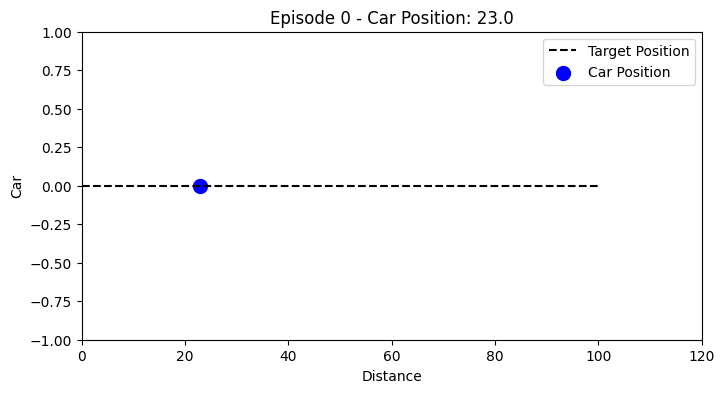

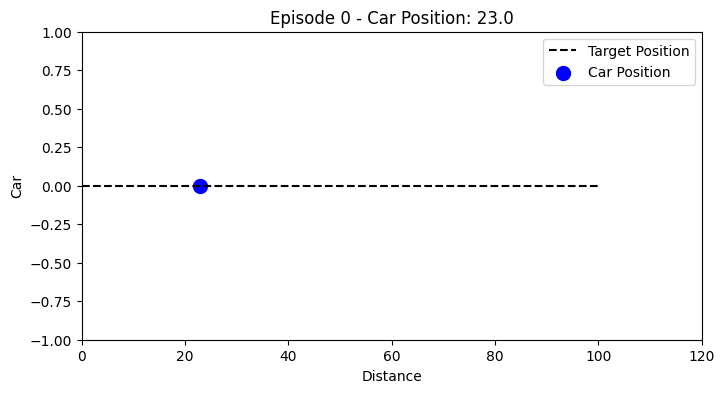

KeyboardInterrupt: 

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 1. Define the car environment
class CarEnv:
    def __init__(self):
        self.position = 0  # Car's current position
        self.speed = 0  # Car's current speed
        self.target_position = 100  # Target position to reach

    def reset(self):
        self.position = 0
        self.speed = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def step(self, action):
        # Action: 0 = decelerate, 1 = maintain speed, 2 = accelerate
        if action == 0:
            self.speed = max(0, self.speed - 1)
        elif action == 2:
            self.speed += 1

        # Move the car forward based on speed
        self.position += self.speed

        # Reward function: Positive reward for distance from target, negative penalty for overshooting
        if self.position >= self.target_position:
            reward = 100  # Reward for reaching the target
            done = True
        else:
            reward = 1  # Small reward for moving forward
            done = False

        return np.array([self.position, self.speed], dtype=np.float32), reward, done

# 2. Define the Liquid Neural Network (LNN)
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.liquid_layer = nn.LSTM(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.tanh(self.input_layer(x))
        h, _ = self.liquid_layer(h.unsqueeze(0))  # Adding sequence dimension
        out = self.output_layer(h.squeeze(0))  # Removing sequence dimension
        return out

# 3. Define the Reinforcement Learning Agent with LNN
class Agent:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.model = LiquidNeuralNetwork(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def get_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_values = self.model(state_tensor)
        action = torch.argmax(action_values).item()  # Pick the action with the highest Q-value
        return action

    def train(self, state, target):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        self.optimizer.zero_grad()
        output = self.model(state_tensor)
        loss = self.loss_fn(output, target_tensor)
        loss.backward()
        self.optimizer.step()

# 4. Real-time visualization of the car's movement
def plot_progress(position, target_position, episode):
    # Clear the previous plot
    clear_output(wait=True)

    # Plot car's current position
    plt.figure(figsize=(8, 4))
    plt.plot([0, target_position], [0, 0], 'k--', label='Target Position')  # Line to target
    plt.scatter(position, 0, color='blue', s=100, label="Car Position")  # Car position

    # Displaying episode and position
    plt.title(f'Episode {episode} - Car Position: {position}')
    plt.xlim(0, target_position + 20)
    plt.ylim(-1, 1)
    plt.legend()
    plt.xlabel('Distance')
    plt.ylabel('Car')

    # Display the plot
    display(plt.gcf())
    plt.pause(0.1)

# 5. Training Loop with Real-time Visualization
def train_agent():
    env = CarEnv()
    agent = Agent(input_size=2, hidden_size=64, output_size=3)
    num_episodes = 1000
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get action from agent
            action = agent.get_action(state)

            # Take action in environment
            next_state, reward, done = env.step(action)

            # Calculate the target for training (TD learning)
            if done:
                target = reward  # Reached the goal, no further future reward
            else:
                target = reward + 0.99 * torch.max(agent.model(torch.tensor(next_state, dtype=torch.float32)))

            # Train the agent
            agent.train(state, target)

            state = next_state
            total_reward += reward

            # Visualize progress
            plot_progress(state[0], env.target_position, episode)

        # Print episode result
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# 6. Run the training
train_agent()


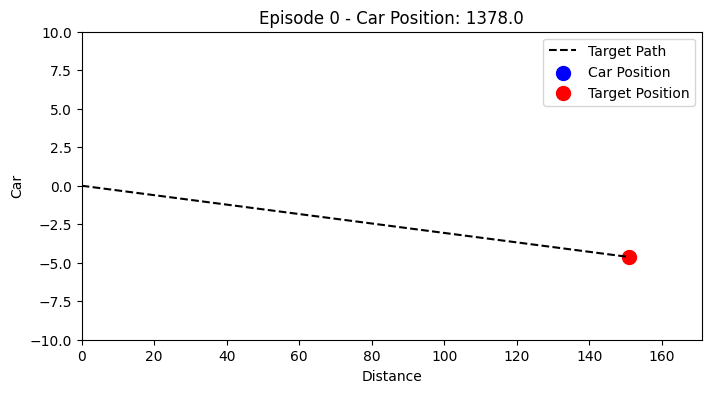

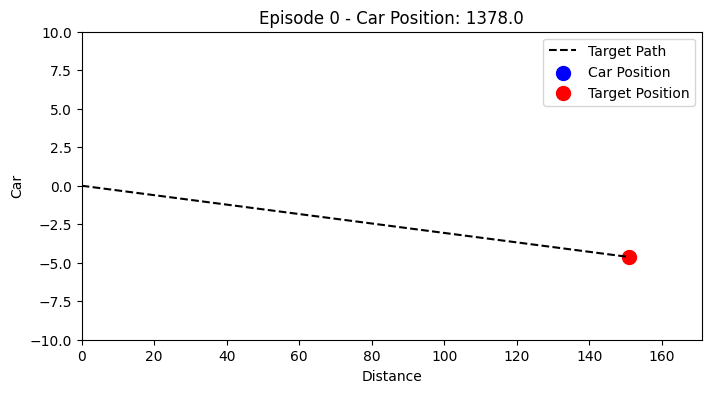

KeyboardInterrupt: 

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 1. Define the car environment with a sine wave target path
class CarEnv:
    def __init__(self):
        self.position = 0  # Car's current position
        self.speed = 0  # Car's current speed
        self.target_position = 100  # Base target position, but we'll move it dynamically
        self.target_wave_amplitude = 5  # Amplitude of the sine wave
        self.target_wave_frequency = 0.1  # Frequency of the sine wave oscillation
        self.time_step = 0  # Time step to control the movement of the wave

    def reset(self):
        self.position = 0
        self.speed = 0
        self.time_step = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def get_target_position(self):
        # Calculate the target position as a sine wave
        target_y = self.target_wave_amplitude * np.sin(self.target_wave_frequency * self.time_step)
        target_x = self.target_position + self.time_step
        self.time_step += 1
        return target_x, target_y

    def step(self, action):
        # Action: 0 = decelerate, 1 = maintain speed, 2 = accelerate
        if action == 0:
            self.speed = max(0, self.speed - 1)
        elif action == 2:
            self.speed += 1

        # Move the car forward based on speed
        self.position += self.speed

        # Get the target position on the sine wave
        target_x, target_y = self.get_target_position()

        # Reward function: Negative reward for distance from target, positive for reaching it
        distance = np.sqrt((self.position - target_x)**2 + target_y**2)
        reward = -distance  # Reward is negative the distance
        done = distance < 5  # Episode ends when car is within 5 units of the target

        return np.array([self.position, self.speed], dtype=np.float32), reward, done, (target_x, target_y)

# 2. Define the Liquid Neural Network (LNN)
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.liquid_layer = nn.LSTM(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.tanh(self.input_layer(x))
        h, _ = self.liquid_layer(h.unsqueeze(0))  # Adding sequence dimension
        out = self.output_layer(h.squeeze(0))  # Removing sequence dimension
        return out

# 3. Define the Reinforcement Learning Agent with LNN
class Agent:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.model = LiquidNeuralNetwork(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def get_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_values = self.model(state_tensor)
        action = torch.argmax(action_values).item()  # Pick the action with the highest Q-value
        return action

    def train(self, state, target):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        self.optimizer.zero_grad()
        output = self.model(state_tensor)
        loss = self.loss_fn(output, target_tensor)
        loss.backward()
        self.optimizer.step()

# 4. Real-time visualization of the car's movement and target (sine wave)
def plot_progress(position, target_position, episode):
    # Clear the previous plot
    clear_output(wait=True)

    # Plot car's current position
    plt.figure(figsize=(8, 4))
    plt.plot([0, target_position[0]], [0, target_position[1]], 'k--', label='Target Path')  # Sine wave path
    plt.scatter(position, 0, color='blue', s=100, label="Car Position")  # Car position
    plt.scatter(target_position[0], target_position[1], color='red', s=100, label="Target Position")  # Current target position

    # Displaying episode and position
    plt.title(f'Episode {episode} - Car Position: {position}')
    plt.xlim(0, target_position[0] + 20)
    plt.ylim(-10, 10)
    plt.legend()
    plt.xlabel('Distance')
    plt.ylabel('Car')

    # Display the plot
    display(plt.gcf())
    plt.pause(0.1)

# 5. Training Loop with Real-time Visualization
def train_agent():
    env = CarEnv()
    agent = Agent(input_size=2, hidden_size=64, output_size=3)
    num_episodes = 1000
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get action from agent
            action = agent.get_action(state)

            # Take action in environment
            next_state, reward, done, target_position = env.step(action)

            # Calculate the target for training (TD learning)
            if done:
                target = reward  # Reached the goal, no further future reward
            else:
                target = reward + 0.99 * torch.max(agent.model(torch.tensor(next_state, dtype=torch.float32)))

            # Train the agent
            agent.train(state, target)

            state = next_state
            total_reward += reward

            # Visualize progress
            plot_progress(state[0], target_position, episode)

        # Print episode result
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# 6. Run the training
train_agent()


KeyboardInterrupt: 

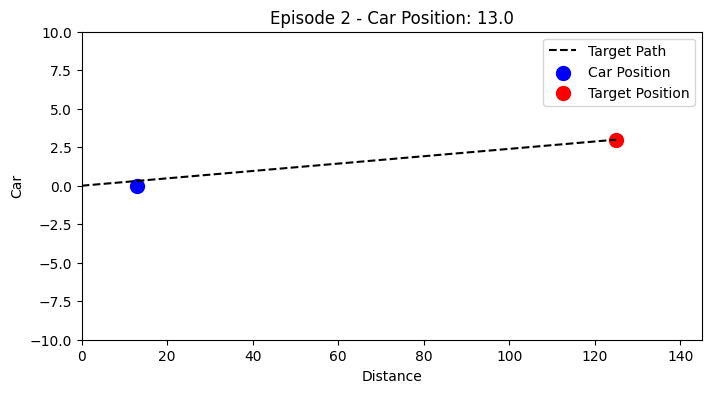

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 1. Define the car environment with a sine wave target path
class CarEnv:
    def __init__(self):
        self.position = 0  # Car's current position
        self.speed = 0  # Car's current speed
        self.target_position = 100  # Base target position, but we'll move it dynamically
        self.target_wave_amplitude = 5  # Amplitude of the sine wave
        self.target_wave_frequency = 0.1  # Frequency of the sine wave oscillation
        self.time_step = 0  # Time step to control the movement of the wave

    def reset(self):
        self.position = 0
        self.speed = 0
        self.time_step = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def get_target_position(self):
        # Calculate the target position as a sine wave
        target_y = self.target_wave_amplitude * np.sin(self.target_wave_frequency * self.time_step)
        target_x = self.target_position + self.time_step
        self.time_step += 1
        return target_x, target_y

    def step(self, action):
        # Action: 0 = decelerate, 1 = maintain speed, 2 = accelerate
        if action == 0:
            self.speed = max(0, self.speed - 1)
        elif action == 2:
            self.speed += 1

        # Move the car forward based on speed
        self.position += self.speed

        # Get the target position on the sine wave
        target_x, target_y = self.get_target_position()

        # Reward function: Encourage the car to get closer to the target
        distance = np.sqrt((self.position - target_x)**2 + target_y**2)
        reward = -distance  # Negative reward for being far from the target
        reward += 0.1 * self.speed  # Encourage higher speeds (but not too much)
        done = distance < 5  # Episode ends when car is within 5 units of the target

        return np.array([self.position, self.speed], dtype=np.float32), reward, done, (target_x, target_y)

# 2. Define the Liquid Neural Network (LNN)
class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LiquidNeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.liquid_layer = nn.LSTM(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.tanh(self.input_layer(x))
        h, _ = self.liquid_layer(h.unsqueeze(0))  # Adding sequence dimension
        out = self.output_layer(h.squeeze(0))  # Removing sequence dimension
        return out

# 3. Define the Reinforcement Learning Agent with LNN
class Agent:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.model = LiquidNeuralNetwork(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.epsilon = epsilon  # Exploration factor
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.min_epsilon = min_epsilon  # Minimum epsilon value

    def get_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_values = self.model(state_tensor)

        # Epsilon-greedy exploration strategy
        if random.random() < self.epsilon:
            return random.choice([0, 1, 2])  # Random action (explore)
        else:
            return torch.argmax(action_values).item()  # Exploit learned policy

    def train(self, state, target):
        state_tensor = torch.tensor(state, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        self.optimizer.zero_grad()
        output = self.model(state_tensor)
        loss = self.loss_fn(output, target_tensor)
        loss.backward()
        self.optimizer.step()

        # Decay epsilon for exploration
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

# 4. Real-time visualization of the car's movement and target (sine wave)
def plot_progress(position, target_position, episode):
    # Clear the previous plot
    clear_output(wait=True)

    # Plot car's current position
    plt.figure(figsize=(8, 4))
    plt.plot([0, target_position[0]], [0, target_position[1]], 'k--', label='Target Path')  # Sine wave path
    plt.scatter(position, 0, color='blue', s=100, label="Car Position")  # Car position
    plt.scatter(target_position[0], target_position[1], color='red', s=100, label="Target Position")  # Current target position

    # Displaying episode and position
    plt.title(f'Episode {episode} - Car Position: {position}')
    plt.xlim(0, target_position[0] + 20)
    plt.ylim(-10, 10)
    plt.legend()
    plt.xlabel('Distance')
    plt.ylabel('Car')

    # Display the plot
    display(plt.gcf())
    plt.pause(0.1)

# 5. Training Loop with Real-time Visualization
def train_agent():
    env = CarEnv()
    agent = Agent(input_size=2, hidden_size=64, output_size=3)
    num_episodes = 1000
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get action from agent
            action = agent.get_action(state)

            # Take action in environment
            next_state, reward, done, target_position = env.step(action)

            # Calculate the target for training (TD learning)
            if done:
                target = reward  # Reached the goal, no further future reward
            else:
                target = reward + 0.99 * torch.max(agent.model(torch.tensor(next_state, dtype=torch.float32)))

            # Train the agent
            agent.train(state, target)

            state = next_state
            total_reward += reward

            # Visualize progress
            plot_progress(state[0], target_position, episode)

        # Print episode result
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# 6. Run the training
train_agent()
